In [ ]:
# Combine Train Data to Full CSV

In [1]:
import os
import time
import numpy as np
import pandas as pd

def export_features_to_csv(split_path, features_dir, output_csv):
    """
    Assemble all precomputed features into one CSV:
      – Columns: citing, cited, split, label, <exact feature names>
      – Reads citation pairs from split_path
      – Reads every .npy/.npz in features_dir
      – Unpacks any 2D arrays into separate columns
      – Uses filenames/keys as column names
    """
    print("INFO: Assembling full feature CSV…")
    t0 = time.time()

    # 1) Load citation pairs
    df_pairs = pd.read_csv(split_path, usecols=["citing","cited","split","label"])
    print(f"INFO: Loaded {len(df_pairs)} pairs in {time.time()-t0:.1f}s")

    # 2) Load all feature arrays into dict
    # 2) Load all feature arrays into dict
    raw = {}
    for fname in os.listdir(features_dir):
        path = os.path.join(features_dir, fname)
        name, ext = os.path.splitext(fname)
    
        if ext == ".npy":
            arr = np.load(path, allow_pickle=True)
            raw[name] = arr
    
        elif ext == ".npz":
            npz = np.load(path, allow_pickle=True)
            for key in npz.files:
                raw[key] = npz[key]
    
        else:
            # αγνοούμε άλλα τύπους αρχείων
            continue

    # 3) Flatten any 2D arrays into individual columns
    data = {}
    for key, arr in raw.items():
        arr = np.asarray(arr)
        if arr.ndim == 1:
            data[key] = arr
        elif arr.ndim == 2:
            # create key_0, key_1, ... for each column
            for j in range(arr.shape[1]):
                data[f"{key}_{j}"] = arr[:, j]
        else:
            raise ValueError(f"Feature '{key}' has {arr.ndim} dimensions (only 1D or 2D supported)")

    # 4) Build DataFrame of features
    df_feats = pd.DataFrame(data)
    print(f"INFO: Loaded {df_feats.shape[1]} feature columns in {time.time()-t0:.1f}s")

    # 5) Concatenate pairs + features
    df_full = pd.concat([df_pairs.reset_index(drop=True), df_feats.reset_index(drop=True)], axis=1)
    print(f"INFO: Full DataFrame shape: {df_full.shape}")

    # 6) Export to CSV
    df_full.to_csv(output_csv, index=False)
    print(f"INFO: Exported full features to {output_csv} in {time.time()-t0:.1f}s")


# Example usage:
if __name__ == "__main__":
    split_path   = r"D:/NLP/tfidf_xgboost/split_train_val/citation_pairs_split_train_val.csv"
    features_dir = r"D:/NLP/Features_XL/train"
    output_csv   = r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv"
    export_features_to_csv(split_path, features_dir, output_csv)


INFO: Assembling full feature CSV…
INFO: Loaded 2183910 pairs in 2.3s
INFO: Loaded 93 feature columns in 15.5s
INFO: Full DataFrame shape: (2183910, 97)
INFO: Exported full features to D:/NLP/Features_XL/train/full_features_correct_h2_train.csv in 156.9s


In [84]:
df_full = pd.read_csv(r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv")

In [85]:
print(len(df_full.columns))

96


In [86]:
print(df_full.columns)

Index(['citing', 'cited', 'label', 'split', 'citing_author_mean_pagerank',
       'cited_author_mean_pagerank', 'citing_author_max_pagerank',
       'cited_author_max_pagerank', 'citing_author_mean_degree',
       'cited_author_mean_degree', 'max_citing_topic_author_dom_cosine',
       'mean_citing_topic_author_dom_cosine',
       'min_citing_topic_author_dom_cosine',
       'max_cited_topic_author_dom_cosine',
       'mean_cited_topic_author_dom_cosine',
       'min_cited_topic_author_dom_cosine', 'author_graph_heuristics_0',
       'author_graph_heuristics_1', 'author_graph_heuristics_2',
       'author_overlap', 'jaccard_authors', 'bertopic_features_0',
       'bertopic_features_1', 'bertopic_features_2', 'bertopic_features_3',
       'bertopic_features_4', 'bertopic_features_5',
       'citation_G_sp_directed_h2', 'coauth_min_dist', 'coauth_mean_dist',
       'coauth_max_dist', 'coauth_inv_min', 'coauth_close_bin', 'co_citation',
       'bibliographic_coupling', 'same_community', '

In [6]:
# Combine Test Data to Full CSV

In [1]:
import os
import time
import numpy as np
import pandas as pd

def export_test_features_to_csv(test_pairs_path, features_dir, output_csv):
    """
    Assemble all precomputed test‐set features into one CSV:
      – Columns: citing, cited, <exact feature names>
      – Handles both .npy (1D or 2D) and .npz files
    """
    print("INFO: Assembling test feature CSV…")
    t0 = time.time()

    # 1) Load test pairs (citing, cited)
    df_pairs = pd.read_csv(
        test_pairs_path,
        header=None,
        names=['citing','cited'],
        dtype={'citing':int,'cited':int}
    )
    print(f"INFO: Loaded {len(df_pairs)} test pairs in {time.time()-t0:.1f}s")

    # 2) Load each feature file
    data = {}
    for fname in sorted(os.listdir(features_dir)):
        path = os.path.join(features_dir, fname)
        name, ext = os.path.splitext(fname)

        if ext == '.npy':
            arr = np.load(path)
            if arr.ndim == 1:
                data[name] = arr
            elif arr.ndim == 2:
                # split into separate columns: name_0, name_1, …
                for j in range(arr.shape[1]):
                    data[f"{name}_{j}"] = arr[:, j]
            else:
                raise ValueError(f"Unsupported .npy shape {arr.shape} for {name}")

        elif ext == '.npz':
            npz = np.load(path)
            for key in npz.files:
                arr = npz[key]
                if arr.ndim == 1:
                    data[key] = arr
                elif arr.ndim == 2:
                    for j in range(arr.shape[1]):
                        data[f"{key}_{j}"] = arr[:, j]
                else:
                    raise ValueError(f"Unsupported .npz array shape {arr.shape} in {name}:{key}")

        else:
            # skip other files
            continue

    # 3) Build DataFrame of all features
    df_feats = pd.DataFrame(data)
    print(f"INFO: Loaded {df_feats.shape[1]} feature columns in {time.time()-t0:.1f}s")

    # 4) Concatenate pairs + features
    df_full = pd.concat(
        [df_pairs.reset_index(drop=True), df_feats.reset_index(drop=True)],
        axis=1
    )
    print(f"INFO: Full test DataFrame shape: {df_full.shape}")

    # 5) Save to CSV
    df_full.to_csv(output_csv, index=False)
    print(f"INFO: Exported test features to {output_csv} in {time.time()-t0:.1f}s")


if __name__ == '__main__':
    test_pairs_path = r"C:\Users\mysmu\Desktop\Natural Language Processing\nlp-cse-uoi-2025\data_new\test.txt"
    features_dir    = r"D:/NLP/Features_XL/test"
    output_csv      = r"D:/NLP/Features_XL/test/full_test_correct_h2_features.csv"

    export_test_features_to_csv(test_pairs_path, features_dir, output_csv)


INFO: Assembling test feature CSV…
INFO: Loaded 106692 test pairs in 0.2s
INFO: Loaded 90 feature columns in 4.3s
INFO: Full test DataFrame shape: (106692, 92)
INFO: Exported test features to D:/NLP/Features_XL/test/full_test_correct_h2_features.csv in 10.8s


In [8]:
test_df_full = pd.read_csv(r"D:/NLP/Features_XL/test/full_test_correct_h2_features.csv")

In [9]:
print(len(test_df_full.columns))
print(test_df_full.columns)

91
Index(['citing', 'cited', 'citing_author_mean_pagerank',
       'cited_author_mean_pagerank', 'citing_author_max_pagerank',
       'cited_author_max_pagerank', 'citing_author_mean_degree',
       'cited_author_mean_degree', 'max_citing_topic_author_dom_cosine',
       'mean_citing_topic_author_dom_cosine',
       'min_citing_topic_author_dom_cosine',
       'max_cited_topic_author_dom_cosine',
       'mean_cited_topic_author_dom_cosine',
       'min_cited_topic_author_dom_cosine', 'author_graph_heuristics_0',
       'author_graph_heuristics_1', 'author_graph_heuristics_2',
       'author_overlap', 'bertopic_features_0', 'bertopic_features_1',
       'bertopic_features_2', 'bertopic_features_3', 'bertopic_features_4',
       'bertopic_features_5', 'bibliographic_coupling',
       'citation_G_adamic_adar', 'citation_G_hub_depressed',
       'citation_G_jaccard', 'citation_G_resource_allocation',
       'citation_G_salton', 'citation_G_sp_directed_h2', 'co_citation',
       'coauth_min

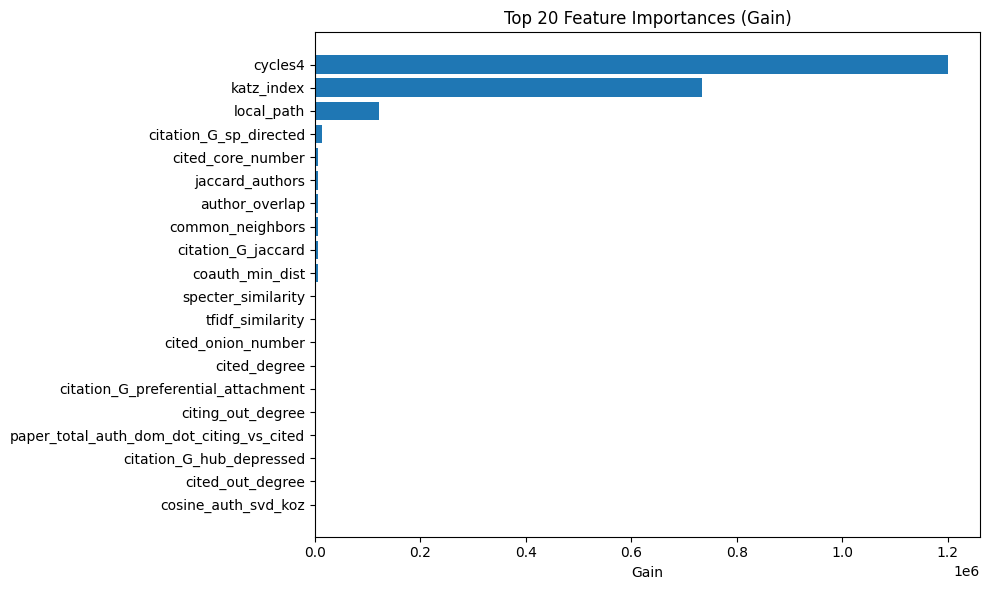

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load a few rows to get the feature names (excluding metadata columns)
csv_path = r"D:/NLP/Features_XL/train/full_features_correct_train.csv"
df_tmp = pd.read_csv(csv_path, nrows=5)
features = [c for c in df_tmp.columns if c not in ['citing','cited','split','label']]

# Extract feature importances (gain) from the trained model
imp_dict = model.get_score(importance_type='gain')
importances = pd.Series(imp_dict, name='gain')
importances = importances.reindex(features).fillna(0.0)
importances = importances.sort_values(ascending=False)

# Select top 20 features
top_k = 20
top_features = importances.head(top_k)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(top_k), top_features.values)
plt.yticks(range(top_k), top_features.index)
plt.gca().invert_yaxis()
plt.xlabel("Gain")
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.show()


In [16]:
# Remove top3 and train

In [10]:
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

def train_with_high_l2(csv_path, features, label_col='label', split_col='split'):
    """
    Train & evaluate XGBoost on GPU with very strong L2 regularization.
    """
    print("INFO: Loading data…")
    t0 = time.time()
    df = pd.read_csv(csv_path)
    print(f"INFO: Loaded {df.shape[0]} rows, {df.shape[1]} cols in {time.time()-t0:.1f}s")

    train_df = df[df[split_col]=='train']
    val_df   = df[df[split_col]=='val']
    X_train, y_train = train_df[features], train_df[label_col]
    X_val,   y_val   = val_df[features],   val_df[label_col]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)

    params = {
        'objective':        'binary:logistic',
        'eval_metric':      ['logloss','auc'],
        'tree_method':      'hist',
        'device':           'cuda',
        'learning_rate':    0.01,
        'max_depth':        15,
        'subsample':        0.5,
        'colsample_bytree': 0.5,
        'lambda':           100.0,   # Very strong L2 regularization
        'alpha':            0.1,     
        'scale_pos_weight': len(y_train[y_train==0]) / max(1,len(y_train[y_train==1])),
        'seed':             42
    }

    print("INFO: Training with lambda=100.0 (L2)…")
    t0 = time.time()
    evals = [(dtrain,'train'),(dval,'val')]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        early_stopping_rounds=50,
        evals=evals,
        verbose_eval=100
    )
    print(f"INFO: Done in {time.time()-t0:.1f}s, best_iter={bst.best_iteration}")

    print("INFO: Predicting on validation…")
    t1 = time.time()
    y_pred = bst.predict(dval)
    ll  = log_loss(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print(f"INFO: Val log-loss={ll:.5f}, AUC={auc:.5f} (in {time.time()-t1:.1f}s)")

    return bst

if __name__ == "__main__":
    csv_path = r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv"
    df0 = pd.read_csv(csv_path, nrows=5)
    feats = [c for c in df0.columns if c not in ['citing','cited','split','label']]
    model_l2 = train_with_high_l2(csv_path, feats)


INFO: Loading data…
INFO: Loaded 2183910 rows, 95 cols in 21.2s
INFO: Training with lambda=100.0 (L2)…
[0]	train-logloss:0.68332	train-auc:0.99786	val-logloss:0.68607	val-auc:0.92897
[100]	train-logloss:0.20190	train-auc:1.00000	val-logloss:0.72530	val-auc:0.97237
[200]	train-logloss:0.07054	train-auc:1.00000	val-logloss:0.87618	val-auc:0.97976
[266]	train-logloss:0.03630	train-auc:1.00000	val-logloss:1.01031	val-auc:0.97971
INFO: Done in 10.7s, best_iter=216
INFO: Predicting on validation…
INFO: Val log-loss=1.01031, AUC=0.97971 (in 0.2s)


In [31]:
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

# 1) Read full features CSV
print("INFO: Loading full features CSV…")
t0 = time.time()
csv_path = r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv"
df = pd.read_csv(csv_path)
print(f"INFO: Loaded {df.shape[0]} rows, {df.shape[1]} cols in {time.time()-t0:.1f}s")



INFO: Loading full features CSV…
INFO: Loaded 2183910 rows, 95 cols in 21.4s


In [ ]:
# Those features should give the same result as before (0.14 on Kaggle) 
#Lets see...

In [48]:
selected_feats =[
        'common_neighbors',
        'citation_G_jaccard', 'citation_G_salton', 
        'citation_G_hub_depressed', 'citation_G_adamic_adar', 
        'tfidf_similarity','citing_degree',

         #'author_G_node2vec_cosine',
    
        #'author_G_node2vec_dot', 'author_G_node2vec_l2',

        #'citation_walklets_cosine', 'citation_walklets_dot', 'citation_walklets_l2',
        
        'author_node2vec_cosine', 'author_node2vec_dot', 'author_node2vec_l2',
        'author_walklets_cosine', 'author_walklets_dot', 'author_walklets_l2',
    
        'max_citing_topic_author_dom_cosine', 'mean_citing_topic_author_dom_cosine',
        'min_citing_topic_author_dom_cosine', 'max_cited_topic_author_dom_cosine', 'mean_cited_topic_author_dom_cosine', 
        'min_cited_topic_author_dom_cosine', 'paper_total_auth_dom_cosine_citing_vs_cited', 'paper_total_auth_dom_dot_citing_vs_cited',
        #'paper_total_auth_dom_citing_vs_citedl2',  'jaccard_authors_koz', 
        'paper_total_auth_dom_l2_citing_vs_cited',  'jaccard_authors', 
        #'paper_total_auth_dom_dot_citing_vs_cited', 
        
        'cosine_abs_svd_koz', 'cosine_auth_svd_koz',
    
        'specter_dot', 
        'specter_cosine',
        'specter_l1',
    
        #'citing_bertopic_dominant_topic', 'cited_bertopic_dominant_topic',
        #'same_bertopic', 'citing_bertopic_topic_entropy', 'cited_bertopic_topic_entropy', 'bertopic_topic_cosine_similarity', 
        'bertopic_features_0', 'bertopic_features_1',
        'bertopic_features_2', 'bertopic_features_3', 'bertopic_features_4','bertopic_features_5',
    
        'author_overlap', 'citing_author_mean_pagerank', 'cited_author_mean_pagerank', 'citing_author_max_pagerank',
        'cited_author_max_pagerank', 'citing_author_mean_degree', 'cited_author_mean_degree', 'citing_in_degree', 'citing_out_degree',
        'cited_in_degree', 'cited_out_degree',  'cited_degree', 'citing_pagerank', 'cited_pagerank',

        'citing_triangles', 'cited_triangles', 'citing_clustering', 'cited_clustering', 'citing_core_number',
        'cited_core_number', 'citing_onion_number',   

        'citation_G_preferential_attachment',

        #-- Best sto far --#
        'same_community', 'scibert_similarity'
        
]



print("INFO: Using features:", selected_feats)

train_data = df[df['split']=='train']
val_data   = df[df['split']=='val']

X_train, y_train = train_data[selected_feats], train_data['label']
X_val,   y_val   = val_data[selected_feats],   val_data['label']

# 3) Pipeline με scaling + LR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_feats)
], remainder="drop")

pipeline = Pipeline([
    ("scaler", preprocessor),
    ("clf",   LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs', n_jobs=-1))
])

# 4) Εκπαίδευση + Αξιολόγηση
pipeline.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score, log_loss

probs = pipeline.predict_proba(X_val)[:,1]
preds = (probs >= 0.5).astype(int)

print("Log Loss:", log_loss(y_val, probs))
print("ROC AUC :", roc_auc_score(y_val, probs))
print("\nClassification Report:\n", classification_report(y_val, preds))

INFO: Using features: ['common_neighbors', 'citation_G_jaccard', 'citation_G_salton', 'citation_G_hub_depressed', 'citation_G_adamic_adar', 'tfidf_similarity', 'citing_degree', 'author_node2vec_cosine', 'author_node2vec_dot', 'author_node2vec_l2', 'author_walklets_cosine', 'author_walklets_dot', 'author_walklets_l2', 'max_citing_topic_author_dom_cosine', 'mean_citing_topic_author_dom_cosine', 'min_citing_topic_author_dom_cosine', 'max_cited_topic_author_dom_cosine', 'mean_cited_topic_author_dom_cosine', 'min_cited_topic_author_dom_cosine', 'paper_total_auth_dom_cosine_citing_vs_cited', 'paper_total_auth_dom_dot_citing_vs_cited', 'paper_total_auth_dom_l2_citing_vs_cited', 'jaccard_authors', 'cosine_abs_svd_koz', 'cosine_auth_svd_koz', 'specter_dot', 'specter_cosine', 'specter_l1', 'bertopic_features_0', 'bertopic_features_1', 'bertopic_features_2', 'bertopic_features_3', 'bertopic_features_4', 'bertopic_features_5', 'author_overlap', 'citing_author_mean_pagerank', 'cited_author_mean_pag

In [35]:
# Submission

In [41]:
import time
import pandas as pd
import xgboost as xgb

# 1) Paths
test_csv      = r"D:/NLP/Features_XL/test/full_test_features.csv"
#model_path    = r"D:/NLP/Features_XL/train/bst_model.json"    # όπου αποθήκευσες το XGBoost μοντέλο
submission_path = r"D:/NLP/Features_XL/test/submission_correct.csv"

# 2) Load test features
print("INFO: Loading test features…")
t0 = time.time()
df_test = pd.read_csv(test_csv)
print(f"INFO: Loaded {len(df_test)} rows in {time.time()-t0:.1f}s")

# 3) Select the same feature columns as training


X_test = df_test[selected_feats]

# 5) Κάνε predict probabilities
print("INFO: Predicting on test set…")
t0 = time.time()
probs = pipeline.predict_proba(X_test)[:,1]
print(f"INFO: Prediction done in {time.time()-t0:.2f}s")

# 6) Φτιάξε το submission frame και γράψε CSV
submission = pd.DataFrame({
    'ID':    df_test.index,   # ή αν έχεις ξεχωριστό index column, χρησιμοποίησέ το
    'Label': probs
})
submission.to_csv(submission_path, index=False)
print(f"INFO: Submission saved to {submission_path}")

INFO: Loading test features…
INFO: Loaded 106692 rows in 1.0s
INFO: Predicting on test set…
INFO: Prediction done in 0.07s
INFO: Submission saved to D:/NLP/Features_XL/test/submission_correct.csv


In [4]:
# Debugging


In [3]:
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

# 1) Read full features CSV
print("INFO: Loading full features CSV…")
t0 = time.time()
csv_path = r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv"
df = pd.read_csv(csv_path)
print(f"INFO: Loaded {df.shape[0]} rows, {df.shape[1]} cols in {time.time()-t0:.1f}s")



INFO: Loading full features CSV…
INFO: Loaded 2183910 rows, 97 cols in 29.2s


Log Loss: 0.12237785439793407
ROC AUC : 0.9898854767228875

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95    109196
           1       0.96      0.94      0.95    109195

    accuracy                           0.95    218391
   macro avg       0.95      0.95      0.95    218391
weighted avg       0.95      0.95      0.95    218391



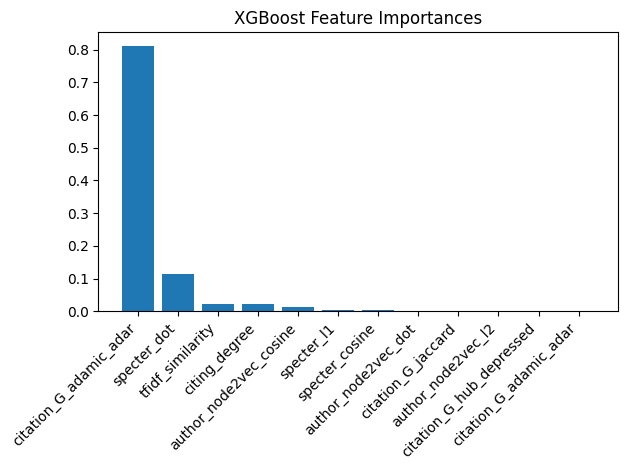

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1) Φόρτωση (αν χρειάζεται, διαφορετικά εξασφαλίστε ότι df υπάρχει στο namespace)
# df = pd.read_csv("path/to/full_features.csv")

# 2) Ορισμός features
selected_feats = [

    'citation_G_adamic_adar', 
    'specter_cosine',
    'specter_dot',
    'specter_l1',

    
    'author_node2vec_cosine', 'author_node2vec_dot', 'author_node2vec_l2',

    #'citation_node2vec_cosine', 'citation_node2vec_dot', 'citation_node2vec_l2',


     #'common_neighbors',
        'citation_G_jaccard', 
    #'citation_G_salton', 
         'citation_G_hub_depressed', 
    'citation_G_adamic_adar', 
      
       'tfidf_similarity','citing_degree',

]

# 3) Διαχωρισμός train/val
train_data = df[df['split']=='train']
val_data   = df[df['split']=='val']

X_train = train_data[selected_feats].values
y_train = train_data['label'].values
X_val   = val_data[selected_feats].values
y_val   = val_data['label'].values

# 4) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 5) Εκπαίδευση XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# 6) Προβλέψεις & metrics
probs = model.predict_proba(X_val_scaled)[:,1]
preds = (probs >= 0.5).astype(int)

print("Log Loss:", log_loss(y_val, probs))
print("ROC AUC :", roc_auc_score(y_val, probs))
print("\nClassification Report:\n", classification_report(y_val, preds))

# 7) Feature importances
importances = model.feature_importances_
feat_imp = sorted(zip(selected_feats, importances), key=lambda x: x[1], reverse=True)
names, values = zip(*feat_imp)

plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()


D:\NLP\gnn_env\lib\site-packages\xgboost\training.py:183: UserWarning: [19:06:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Log Loss: 0.11770115390179223
ROC AUC : 0.9906263228690837

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    109196
           1       0.97      0.95      0.96    109195

    accuracy                           0.96    218391
   macro avg       0.96      0.96      0.96    218391
weighted avg       0.96      0.96      0.96    218391



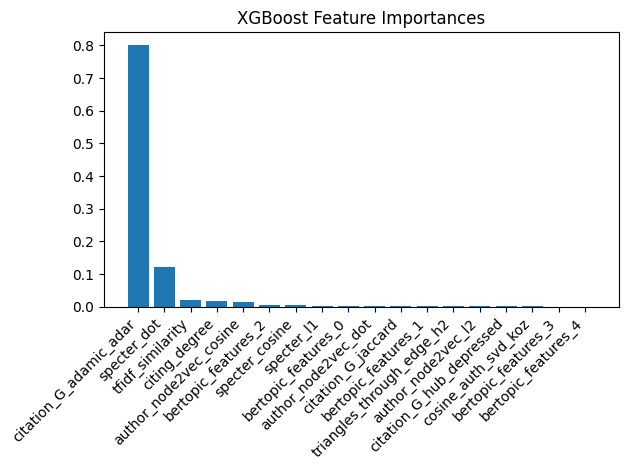

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1) Φόρτωση (αν χρειάζεται, διαφορετικά εξασφαλίστε ότι df υπάρχει στο namespace)
# df = pd.read_csv("path/to/full_features.csv")

# 2) Ορισμός features
selected_feats = [
    #'local_path_h2',
    #'citation_G_sp_directed_h2',
    'triangles_through_edge_h2',
    #'katz_index_h2',
    
    #'cycles4_h2',
    'specter_cosine',
    'specter_dot',
    'specter_l1',
    

    'author_node2vec_cosine', 'author_node2vec_dot', 'author_node2vec_l2',

    #'citation_node2vec_cosine', 'citation_node2vec_dot', 'citation_node2vec_l2',


     #'common_neighbors',
        'citation_G_jaccard', 
    #'citation_G_salton', 
         'citation_G_hub_depressed', 
    'citation_G_adamic_adar', 
      
       'tfidf_similarity','citing_degree',
    

    # BEST SO FAR
     #'cosine_abs_svd_koz', 
    'cosine_auth_svd_koz',

   

    'bertopic_features_0', 'bertopic_features_1',
    'bertopic_features_2', 
    'bertopic_features_3', 'bertopic_features_4',
    #'bertopic_features_5',


# BEST SO FAR

        
  
      
    
]

# 3) Διαχωρισμός train/val
train_data = df[df['split']=='train']
val_data   = df[df['split']=='val']

X_train = train_data[selected_feats].values
y_train = train_data['label'].values
X_val   = val_data[selected_feats].values
y_val   = val_data['label'].values

# 4) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 5) Εκπαίδευση XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# 6) Προβλέψεις & metrics
probs = model.predict_proba(X_val_scaled)[:,1]
preds = (probs >= 0.5).astype(int)

print("Log Loss:", log_loss(y_val, probs))
print("ROC AUC :", roc_auc_score(y_val, probs))
print("\nClassification Report:\n", classification_report(y_val, preds))

# 7) Feature importances
importances = model.feature_importances_
feat_imp = sorted(zip(selected_feats, importances), key=lambda x: x[1], reverse=True)
names, values = zip(*feat_imp)

plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()


# Submission #  19/05/2025 19:02 -> 0.1

In [5]:
# 1) Paths
test_csv        = r"D:/NLP/Features_XL/test/full_test_correct_h2_features.csv"
submission_path = r"D:/NLP/Features_XL/test/submission_correct_h2_xgb.csv"

# 2) Load test features
print("INFO: Loading test features…")
t0 = time.time()
df_test = pd.read_csv(test_csv)
print(f"INFO: Loaded {len(df_test)} rows in {time.time()-t0:.1f}s")

# 3) Select the same feature columns as training
# Βεβαιώσου ότι το selected_feats έχει οριστεί κάπου πριν από αυτό το σημείο
# και ότι περιέχει τα ίδια χαρακτηριστικά που χρησιμοποιήθηκαν στην εκπαίδευση.
X_test = df_test[selected_feats].values

# 4) Scale with your trained scaler
# Βεβαιώσου ότι ο scaler έχει εκπαιδευτεί (fit) στο training data.
X_test_scaled = scaler.transform(X_test)

# 5) Predict probabilities with your XGBoost model
print("INFO: Predicting on test set…")
t0 = time.time()
# Εδώ είναι η σημαντική αλλαγή: χρησιμοποιούμε το 'model' (XGBoost) αντί για 'mlp'
probs = model.predict_proba(X_test_scaled)[:, 1]
print(f"INFO: Prediction done in {time.time()-t0:.2f}s")

# 6) Build submission DataFrame and save CSV
submission = pd.DataFrame({
    'ID':    df_test.index,  # Ή το κατάλληλο index/identifier, π.χ., df_test['original_ID_column']
    'Label': probs
})
submission.to_csv(submission_path, index=False)
print(f"INFO: Submission saved to {submission_path}")

INFO: Loading test features…
INFO: Loaded 106692 rows in 2.3s
INFO: Predicting on test set…
INFO: Prediction done in 0.04s
INFO: Submission saved to D:/NLP/Features_XL/test/submission_correct_h2_xgb.csv


Log Loss: 0.11850590564536487
ROC AUC : 0.9904899466742638

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    109196
           1       0.97      0.95      0.96    109195

    accuracy                           0.96    218391
   macro avg       0.96      0.96      0.96    218391
weighted avg       0.96      0.96      0.96    218391



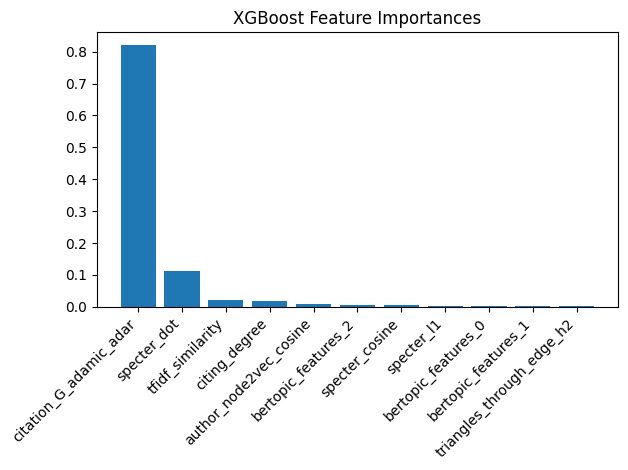

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1) Φόρτωση (αν χρειάζεται, διαφορετικά εξασφαλίστε ότι df υπάρχει στο namespace)
# df = pd.read_csv("path/to/full_features.csv")

# 2) Ορισμός features
selected_feats = [
    #'local_path_h2',
    #'citation_G_sp_directed_h2',
    'triangles_through_edge_h2', #matters less
   # 'katz_index_h2',
    
    #'cycles4_h2',
    'specter_cosine',# important
    'specter_dot',# sos
    'specter_l1',# matters less

    #'author_node2vec_cosine', 'author_node2vec_dot', 'author_node2vec_l2',

    #'citation_node2vec_cosine', 'citation_node2vec_dot', 'citation_node2vec_l2',


     #'common_neighbors',
        #'citation_G_jaccard', 
    #'citation_G_salton', 
        # 'citation_G_hub_depressed', 
    'citation_G_adamic_adar', # sos
      
       'tfidf_similarity','citing_degree',# importatnt
     'author_node2vec_cosine',#importatnt
    

    # BEST SO FAR
     #'cosine_abs_svd_koz', 
    #'cosine_auth_svd_koz',

   

    'bertopic_features_0', 'bertopic_features_1',# important-matters less
    'bertopic_features_2', 
    #'bertopic_features_3', 'bertopic_features_4',
    #'bertopic_features_5',


# BEST SO FAR

        
  
      
    
]

# 3) Διαχωρισμός train/val
train_data = df[df['split']=='train']
val_data   = df[df['split']=='val']

X_train = train_data[selected_feats].values
y_train = train_data['label'].values
X_val   = val_data[selected_feats].values
y_val   = val_data['label'].values

# 4) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 5) Εκπαίδευση XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# 6) Προβλέψεις & metrics
probs = model.predict_proba(X_val_scaled)[:,1]
preds = (probs >= 0.5).astype(int)

print("Log Loss:", log_loss(y_val, probs))
print("ROC AUC :", roc_auc_score(y_val, probs))
print("\nClassification Report:\n", classification_report(y_val, preds))

# 7) Feature importances
importances = model.feature_importances_
feat_imp = sorted(zip(selected_feats, importances), key=lambda x: x[1], reverse=True)
names, values = zip(*feat_imp)

plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()


In [65]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    model, X_val_scaled, y_val, 
    scoring="neg_log_loss", n_repeats=10, random_state=42
)
perm_imp = sorted(zip(selected_feats, r.importances_mean), key=lambda x: x[1], reverse=True)
for feat, imp in perm_imp:
    print(f"{feat:30s}  {imp:.4f}")


citation_G_adamic_adar          0.7903
citing_degree                   0.1365
specter_dot                     0.1079
tfidf_similarity                0.0971
author_node2vec_cosine          0.0680
specter_l1                      0.0155
bertopic_features_2             0.0119
bertopic_features_0             0.0076
specter_cosine                  0.0056
bertopic_features_1             0.0033


In [66]:
from sklearn.metrics import classification_report

# υποθέτουμε ότι 'probs' και 'preds' είναι ήδη υπολογισμένα
print(classification_report(y_val, preds, digits=4))


              precision    recall  f1-score   support

           0     0.9464    0.9664    0.9562    109196
           1     0.9656    0.9452    0.9553    109195

    accuracy                         0.9558    218391
   macro avg     0.9560    0.9558    0.9558    218391
weighted avg     0.9560    0.9558    0.9558    218391



In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss
import optuna
import warnings

# Σίγαση του προειδοποιητικού μηνύματος "use_label_encoder"
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# 1) Φόρτωση df (αν δεν είναι ήδη φορτωμένο)
# df = pd.read_csv("path/to/full_features.csv")

# 2) Ορισμός features
selected_feats = [
    'triangles_through_edge_h2',
    'specter_cosine',
    'specter_dot',
    'specter_l1',
    'citation_G_adamic_adar',
    'tfidf_similarity',
    'citing_degree',
    'author_node2vec_cosine',
    'bertopic_features_0',
    'bertopic_features_1',
    'bertopic_features_2',
]

# 3) Διαχωρισμός train/val
train_data = df[df['split']=='train']
val_data   = df[df['split']=='val']

X_train = train_data[selected_feats].values
y_train = train_data['label'].values
X_val   = val_data[selected_feats].values
y_val   = val_data['label'].values

# 4) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 5) Ορισμός objective για Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'n_jobs': -1,
        'early_stopping_rounds': 50,   # ← στον constructor
    }
    model = XGBClassifier(**params, use_label_encoder=False)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        verbose=False
    )
    
    # πάρτε την καλύτερη επανάληψη
    best_iter = model.best_iteration or model.n_estimators

    # προβλέψεις με iteration_range
    probs = model.predict_proba(
        X_val_scaled,
        iteration_range=(0, best_iter+1)
    )[:, 1]
    
    return log_loss(y_val, probs)

# 6) Εκτέλεση Optuna
study = optuna.create_study(direction='minimize', study_name='XGBoost_LogLoss_Optimization')
study.optimize(objective, n_trials=100)

print("\n--- Optuna Optimization Results ---")
print(f"Best trial: {study.best_trial.number}")
print(f"Best Log Loss: {study.best_value}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 7) Τελικό μοντέλο με τις καλύτερες παραμέτρους
print("\n--- Training Final Model with Best Hyperparameters ---")
final_params = study.best_params.copy()
final_params.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'early_stopping_rounds': 50
})
final_model = XGBClassifier(**final_params)
final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

# 8) Τελικές προβλέψεις & metrics
best_iter_final = final_model.best_iteration or final_model.n_estimators
probs_final = final_model.predict_proba(
    X_val_scaled,
    iteration_range=(0, best_iter_final+1)
)[:, 1]
preds_final = (probs_final >= 0.5).astype(int)

print("\n--- Final Model Performance ---")
print("Log Loss:", log_loss(y_val, probs_final))
print("ROC AUC :", roc_auc_score(y_val, probs_final))
print("\nClassification Report:\n", classification_report(y_val, preds_final))

# 9) Feature importances
print("\n--- Final Model Feature Importances ---")
importances_final = final_model.feature_importances_
feat_imp_final = sorted(zip(selected_feats, importances_final), key=lambda x: x[1], reverse=True)
names_final, values_final = zip(*feat_imp_final)

plt.figure(figsize=(10, 6))
plt.bar(range(len(values_final)), values_final)
plt.xticks(range(len(names_final)), names_final, rotation=45, ha='right')
plt.title('XGBoost Feature Importances (Final Model)')
plt.tight_layout()
plt.show()


[I 2025-05-29 13:57:43,517] A new study created in memory with name: XGBoost_LogLoss_Optimization
[I 2025-05-29 13:58:21,233] Trial 0 finished with value: 0.11773878032738315 and parameters: {'n_estimators': 598, 'learning_rate': 0.09920303066714868, 'max_depth': 6, 'subsample': 0.6732041121066116, 'colsample_bytree': 0.8829549983600735, 'gamma': 0.03394313282939104, 'lambda': 0.0001335169145247829, 'alpha': 0.00026299802613623566}. Best is trial 0 with value: 0.11773878032738315.
[I 2025-05-29 13:58:35,104] Trial 1 finished with value: 0.1181853527344408 and parameters: {'n_estimators': 615, 'learning_rate': 0.1805363638148086, 'max_depth': 10, 'subsample': 0.8114599392476859, 'colsample_bytree': 0.8435598922941938, 'gamma': 0.2084743710898801, 'lambda': 0.0001807035141938019, 'alpha': 1.0748431350715e-05}. Best is trial 0 with value: 0.11773878032738315.
[I 2025-05-29 13:58:58,671] Trial 2 finished with value: 0.11807040616968686 and parameters: {'n_estimators': 972, 'learning_rate':

KeyboardInterrupt: 

In [21]:
selected_feats =[
            'common_neighbors',
         
         'citation_G_jaccard', 'citation_G_salton', 
        'citation_G_hub_depressed', 'citation_G_adamic_adar', 
        'tfidf_similarity','citing_degree',



         #'author_G_node2vec_cosine', 'author_G_node2vec_dot', 'author_G_node2vec_l2',
    #'paper_total_auth_dom_citing_vs_citedl2',  'jaccard_authors_koz',
    # 'citing_bertopic_dominant_topic', 'cited_bertopic_dominant_topic',
    #'same_bertopic', 'citing_bertopic_topic_entropy', 'cited_bertopic_topic_entropy', 'bertopic_topic_cosine_similarity', 

    
    
    'max_citing_topic_author_dom_cosine', 'mean_citing_topic_author_dom_cosine',
        'min_citing_topic_author_dom_cosine', 'max_cited_topic_author_dom_cosine', 'mean_cited_topic_author_dom_cosine', 
        'min_cited_topic_author_dom_cosine', 'paper_total_auth_dom_cosine_citing_vs_cited', 'paper_total_auth_dom_dot_citing_vs_cited',
          'cosine_abs_svd_koz', 'cosine_auth_svd_koz',
    
        'specter_similarity',
        'author_overlap', 'citing_author_mean_pagerank', 'cited_author_mean_pagerank', 'citing_author_max_pagerank',
        'cited_author_max_pagerank', 'citing_author_mean_degree', 'cited_author_mean_degree', 'citing_in_degree', 'citing_out_degree',
        'cited_in_degree', 'cited_out_degree',  'cited_degree', 'citing_pagerank', 'cited_pagerank',

        'citing_triangles', 'cited_triangles', 'citing_clustering', 'cited_clustering', 'citing_core_number',
        'cited_core_number', 'citing_onion_number',
   
        ]
print("INFO: Using features:", selected_feats)

# 3) Split into train/val by the existing 'split' column
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']
print(f"INFO: Train size={len(train_df)}, Val size={len(val_df)}")

X_train = train_df[selected_feats]
y_train = train_df['label']
X_val   = val_df[selected_feats]
y_val   = val_df['label']

# 4) Build DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# 5) Train a quick GPU XGBoost as a test
params = {
    'objective':      'binary:logistic',
    'eval_metric':    ['logloss','auc'],
    'tree_method':    'hist',
    'device':         'cuda',
    'learning_rate':  0.01,
    'max_depth':      5,
    'subsample':      0.8,
    'colsample_bytree':0.8,
    'lambda':         10.0,
    'alpha':          0.1,
    'seed':           42
}
print("INFO: Training XGBoost on selected features…")
t0 = time.time()
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain,'train'),(dval,'val')],
    verbose_eval=50
)
print(f"INFO: Training done in {time.time()-t0:.1f}s, best_iter={bst.best_iteration}")

# 6) Evaluate
t1 = time.time()
y_pred = bst.predict(dval)
ll  = log_loss(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print(f"INFO: Validation log-loss={ll:.5f}, AUC={auc:.5f} (in {time.time()-t1:.1f}s)")

INFO: Using features: ['common_neighbors', 'citation_G_jaccard', 'citation_G_salton', 'citation_G_hub_depressed', 'citation_G_adamic_adar', 'tfidf_similarity', 'citing_degree', 'max_citing_topic_author_dom_cosine', 'mean_citing_topic_author_dom_cosine', 'min_citing_topic_author_dom_cosine', 'max_cited_topic_author_dom_cosine', 'mean_cited_topic_author_dom_cosine', 'min_cited_topic_author_dom_cosine', 'paper_total_auth_dom_cosine_citing_vs_cited', 'paper_total_auth_dom_dot_citing_vs_cited', 'cosine_abs_svd_koz', 'cosine_auth_svd_koz', 'specter_similarity', 'author_overlap', 'citing_author_mean_pagerank', 'cited_author_mean_pagerank', 'citing_author_max_pagerank', 'cited_author_max_pagerank', 'citing_author_mean_degree', 'cited_author_mean_degree', 'citing_in_degree', 'citing_out_degree', 'cited_in_degree', 'cited_out_degree', 'cited_degree', 'citing_pagerank', 'cited_pagerank', 'citing_triangles', 'cited_triangles', 'citing_clustering', 'cited_clustering', 'citing_core_number', 'cited_c

In [54]:

# 2) Select only the columns you specified + metadata
selected_feats = [
    'common_neighbors',
    #'citation_G_sp_directed',
    #'scibert_similarity',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',

    'same_community',
    'comm_size_ratio', 
    'keyword_jaccard',

    'citing_degree', 
    
    'lda_topics_similarity',
    # 'author_graph_heuristics_0',
    # 'author_graph_heuristics_1', 'author_graph_heuristics_2',
    'author_overlap',
    
   
  



    #'katz_index', 
    #'local_path',

    #'cycles4'

    # 'citing_author_mean_pagerank',
    #    'cited_author_mean_pagerank', 'citing_author_max_pagerank',
    #    'cited_author_max_pagerank', 'citing_author_mean_degree',
    #    'cited_author_mean_degree', 'max_citing_topic_author_dom_cosine',
    #    'mean_citing_topic_author_dom_cosine',
    #    'min_citing_topic_author_dom_cosine',
    #    'max_cited_topic_author_dom_cosine',
    #    'mean_cited_topic_author_dom_cosine',
    #    'min_cited_topic_author_dom_cosine', 'author_graph_heuristics_0',
    #    'author_graph_heuristics_1', 'author_graph_heuristics_2',
    #    'author_overlap', 'jaccard_authors', 'bertopic_features_0',
    #    'bertopic_features_1', 'bertopic_features_2', 'bertopic_features_3',
    #    'bertopic_features_4', 'bertopic_features_5', 'coauth_min_dist',
    #    'coauth_mean_dist', 'coauth_max_dist', 'coauth_inv_min',
    #    'coauth_close_bin', 'co_citation', 'bibliographic_coupling',
    
  


    # 'same_community', 'comm_size_ratio', 'keyword_jaccard',
    #    'lda_topics_similarity', 'triangles', 'cycles4', 'citing_in_degree',
    #    'citing_out_degree', 'citing_degree', 'cited_in_degree',
    #    'cited_out_degree', 'cited_degree', 'citing_pagerank', 'cited_pagerank',
    #    'citing_triangles', 'cited_triangles', 'citing_clustering',
    #    'cited_clustering', 'citing_core_number', 'cited_core_number',
    #    'citing_onion_number', 'cited_onion_number', 'citing_eigenvector',
    #    'cited_eigenvector', 'common_neighbors', 'citation_G_jaccard',
    #    'citation_G_salton', 'citation_G_hub_depressed',
    #    'citation_G_adamic_adar', 'citation_G_resource_allocation',
    #    'citation_G_preferential_attachment', 'citation_G_sp_directed',
    #    'paper_total_auth_dom_cosine_citing_vs_cited',
    #    'paper_total_auth_dom_dot_citing_vs_cited',
    #    'paper_total_auth_dom_l2_citing_vs_cited', 'katz_index', 'local_path',
    #    'scibert_similarity', 'specter_similarity', 'cosine_abs_svd_koz',
    #    'cosine_auth_svd_koz', 
]
print("INFO: Using features:", selected_feats)

# 3) Split into train/val by the existing 'split' column
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']
print(f"INFO: Train size={len(train_df)}, Val size={len(val_df)}")

X_train = train_df[selected_feats]
y_train = train_df['label']
X_val   = val_df[selected_feats]
y_val   = val_df['label']

# 4) Build DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# 5) Train a quick GPU XGBoost as a test
params = {
    'objective':      'binary:logistic',
    'eval_metric':    ['logloss','auc'],
    'tree_method':    'hist',
    'device':         'cuda',
    'learning_rate':  0.01,
    'max_depth':      5,
    'subsample':      0.8,
    'colsample_bytree':0.8,
    'lambda':         10.0,
    'alpha':          0.1,
    'seed':           42
}
print("INFO: Training XGBoost on selected features…")
t0 = time.time()
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain,'train'),(dval,'val')],
    verbose_eval=50
)
print(f"INFO: Training done in {time.time()-t0:.1f}s, best_iter={bst.best_iteration}")

# 6) Evaluate
t1 = time.time()
y_pred = bst.predict(dval)
ll  = log_loss(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print(f"INFO: Validation log-loss={ll:.5f}, AUC={auc:.5f} (in {time.time()-t1:.1f}s)")

INFO: Using features: ['common_neighbors', 'specter_similarity', 'tfidf_similarity', 'co_citation', 'bibliographic_coupling', 'jaccard_authors', 'citation_G_jaccard', 'same_community', 'comm_size_ratio', 'keyword_jaccard', 'citing_degree', 'lda_topics_similarity', 'author_overlap']
INFO: Train size=1965519, Val size=218391
INFO: Training XGBoost on selected features…
[0]	train-logloss:0.68501	train-auc:0.98079	val-logloss:0.68506	val-auc:0.97779
[50]	train-logloss:0.41409	train-auc:0.98851	val-logloss:0.41628	val-auc:0.98639
[100]	train-logloss:0.28436	train-auc:0.98930	val-logloss:0.28811	val-auc:0.98713
[150]	train-logloss:0.21461	train-auc:0.98984	val-logloss:0.21950	val-auc:0.98774
[200]	train-logloss:0.17441	train-auc:0.99030	val-logloss:0.18050	val-auc:0.98816
[250]	train-logloss:0.15120	train-auc:0.99059	val-logloss:0.15850	val-auc:0.98843
[300]	train-logloss:0.13744	train-auc:0.99085	val-logloss:0.14562	val-auc:0.98878
[350]	train-logloss:0.12909	train-auc:0.99105	val-logloss:0

In [55]:
# Αποθήκευση σε JSON (ή σε binary .bin)
model_path = r"D:/NLP/Features_XL/train/xgb_model.json"
bst.save_model(model_path)
print(f"INFO: Saved XGBoost model to {model_path}")

INFO: Saved XGBoost model to D:/NLP/Features_XL/train/xgb_model.json


In [2]:
import pandas as pd

# 1) Extract feature importances by gain
imp_dict = bst.get_score(importance_type='gain')
imp_ser  = pd.Series(imp_dict, name='gain')

# 2) Reindex to include any missing features at zero
selected = [
    'common_neighbors',
    'citation_G_sp_directed',
    'scibert_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard'
]
imp_ser = imp_ser.reindex(selected).fillna(0.0)

# 3) Sort descending and print
imp_ser = imp_ser.sort_values(ascending=False)
print("Feature importances (by gain):")
print(imp_ser)


Feature importances (by gain):
citation_G_sp_directed    203462.765625
common_neighbors           29566.662109
citation_G_jaccard         18485.845703
tfidf_similarity            8142.448242
jaccard_authors             6388.615234
scibert_similarity          3212.427002
co_citation                   94.801682
bibliographic_coupling        45.222446
Name: gain, dtype: float64


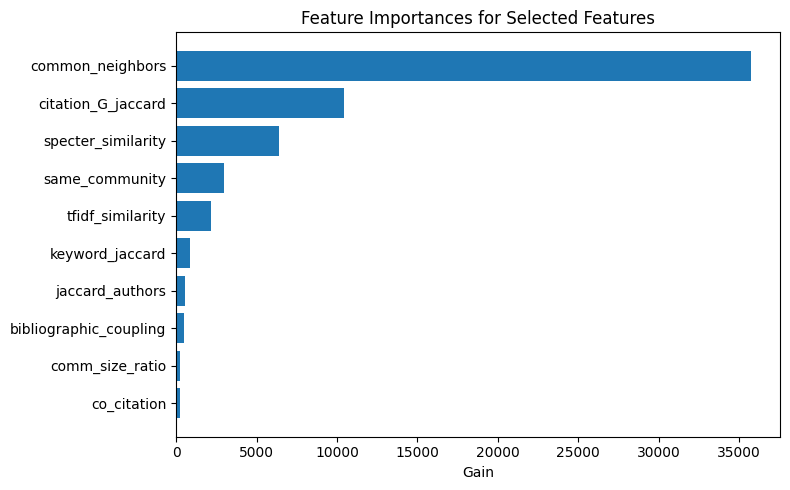

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Define the same selected features
selected_features = [
    'common_neighbors',
    #'citation_G_sp_directed',
    #'scibert_similarity',
    'specter_similarity',
    'tfidf_similarity',
    #'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',

    'same_community',
    #'comm_size_ratio', 
    #'keyword_jaccard',

    #'katz_index', 
    #'local_path',

    #'cycles4'
  
]

# 2) Extract gain importances from your trained Booster (bst)
imp_dict = bst.get_score(importance_type='gain')
imp_series = pd.Series(imp_dict, name='gain')

# 3) Ensure all features are present, fill missing with 0
imp_series = imp_series.reindex(selected_features).fillna(0.0)

# 4) Sort ascending so the largest appears at the top of the horizontal bar chart
imp_series = imp_series.sort_values(ascending=True)

# 5) Plot
plt.figure(figsize=(8, 5))
plt.barh(imp_series.index, imp_series.values)
plt.xlabel("Gain")
plt.title("Feature Importances for Selected Features")
plt.tight_layout()
plt.show()


In [58]:
# Test on Unseen Data

In [57]:
import os
import time
import numpy as np
import pandas as pd
import xgboost as xgb

# 1) Paths & settings
model_path           = r"D:/NLP/Features_XL/train/xgb_model.json"
test_pairs_path      = r"C:\Users\mysmu\Desktop\Natural Language Processing\nlp-cse-uoi-2025\data_new\test.txt"
features_dir         = r"D:/NLP/Features_XL/test"
submission_path      = r"D:/NLP/Features_XL/test/submission.csv"

# 2) Load test pairs so we can attach predictions
df_test = pd.read_csv(test_pairs_path, header=None, names=['citing','cited'])

# 3) Load precomputed test features
data = {}
for fname in os.listdir(features_dir):
    path = os.path.join(features_dir, fname)
    name, ext = os.path.splitext(fname)
    if ext == ".npy":
        data[name] = np.load(path)
    elif ext == ".npz":
        arr = np.load(path)
        for key in arr.files:
            data[key] = arr[key]
df_feats = pd.DataFrame(data)

# 4) Select exactly the features you used in training
selected_feats = [
    'common_neighbors',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',
    'same_community',
    'comm_size_ratio',
    'keyword_jaccard',
    'citing_degree',
    'lda_topics_similarity',
    'author_overlap'
]
X_test = df_feats[selected_feats]

# 5) Load the trained XGBoost model
bst = xgb.Booster()
bst.load_model(model_path)

# 6) Predict on the test set
dtest = xgb.DMatrix(X_test)
print("INFO: Running predictions…")
t0 = time.time()
preds = bst.predict(dtest)
print(f"INFO: Predictions done in {time.time()-t0:.1f}s")

# 7) Save submission CSV
df_sub = df_test.copy()
df_sub['prediction'] = preds
df_sub.to_csv(submission_path, index=False)
print(f"INFO: Submission saved to {submission_path}")


KeyError: "['common_neighbors', 'same_community', 'comm_size_ratio', 'keyword_jaccard', 'citing_degree'] not in index"

In [ ]:
# Train v2 

In [ ]:

# 2) Select only the columns you specified + metadata
selected_feats = [
    'common_neighbors',
    #'citation_G_sp_directed',
    #'scibert_similarity',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',

    'same_community',
    'comm_size_ratio', 
    'keyword_jaccard',

    'citing_degree', 
    
    'lda_topics_similarity',
    # 'author_graph_heuristics_0',
    # 'author_graph_heuristics_1', 'author_graph_heuristics_2',
    'author_overlap',
    
   
  



    #'katz_index', 
    #'local_path',

    #'cycles4'

    # 'citing_author_mean_pagerank',
    #    'cited_author_mean_pagerank', 'citing_author_max_pagerank',
    #    'cited_author_max_pagerank', 'citing_author_mean_degree',
    #    'cited_author_mean_degree', 'max_citing_topic_author_dom_cosine',
    #    'mean_citing_topic_author_dom_cosine',
    #    'min_citing_topic_author_dom_cosine',
    #    'max_cited_topic_author_dom_cosine',
    #    'mean_cited_topic_author_dom_cosine',
    #    'min_cited_topic_author_dom_cosine', 'author_graph_heuristics_0',
    #    'author_graph_heuristics_1', 'author_graph_heuristics_2',
    #    'author_overlap', 'jaccard_authors', 'bertopic_features_0',
    #    'bertopic_features_1', 'bertopic_features_2', 'bertopic_features_3',
    #    'bertopic_features_4', 'bertopic_features_5', 'coauth_min_dist',
    #    'coauth_mean_dist', 'coauth_max_dist', 'coauth_inv_min',
    #    'coauth_close_bin', 'co_citation', 'bibliographic_coupling',
    
  


    # 'same_community', 'comm_size_ratio', 'keyword_jaccard',
    #    'lda_topics_similarity', 'triangles', 'cycles4', 'citing_in_degree',
    #    'citing_out_degree', 'citing_degree', 'cited_in_degree',
    #    'cited_out_degree', 'cited_degree', 'citing_pagerank', 'cited_pagerank',
    #    'citing_triangles', 'cited_triangles', 'citing_clustering',
    #    'cited_clustering', 'citing_core_number', 'cited_core_number',
    #    'citing_onion_number', 'cited_onion_number', 'citing_eigenvector',
    #    'cited_eigenvector', 'common_neighbors', 'citation_G_jaccard',
    #    'citation_G_salton', 'citation_G_hub_depressed',
    #    'citation_G_adamic_adar', 'citation_G_resource_allocation',
    #    'citation_G_preferential_attachment', 'citation_G_sp_directed',
    #    'paper_total_auth_dom_cosine_citing_vs_cited',
    #    'paper_total_auth_dom_dot_citing_vs_cited',
    #    'paper_total_auth_dom_l2_citing_vs_cited', 'katz_index', 'local_path',
    #    'scibert_similarity', 'specter_similarity', 'cosine_abs_svd_koz',
    #    'cosine_auth_svd_koz', 
]
print("INFO: Using features:", selected_feats)

# 3) Split into train/val by the existing 'split' column
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']
print(f"INFO: Train size={len(train_df)}, Val size={len(val_df)}")

X_train = train_df[selected_feats]
y_train = train_df['label']
X_val   = val_df[selected_feats]
y_val   = val_df['label']

# 4) Build DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# 5) Train a quick GPU XGBoost as a test
params = {
    'objective':      'binary:logistic',
    'eval_metric':    ['logloss','auc'],
    'tree_method':    'hist',
    'device':         'cuda',
    'learning_rate':  0.01,
    'max_depth':      5,
    'subsample':      0.8,
    'colsample_bytree':0.8,
    'lambda':         10.0,
    'alpha':          0.1,
    'seed':           42
}
print("INFO: Training XGBoost on selected features…")
t0 = time.time()
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain,'train'),(dval,'val')],
    verbose_eval=50
)
print(f"INFO: Training done in {time.time()-t0:.1f}s, best_iter={bst.best_iteration}")

# 6) Evaluate
t1 = time.time()
y_pred = bst.predict(dval)
ll  = log_loss(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print(f"INFO: Validation log-loss={ll:.5f}, AUC={auc:.5f} (in {time.time()-t1:.1f}s)")

In [59]:
from sklearn.metrics import classification_report

# 7) Classification report at default threshold 0.5
print("INFO: Generating classification report on validation set…")
y_pred_label = (y_pred >= 0.5).astype(int)
report = classification_report(y_val, y_pred_label, digits=4)
print(report)


INFO: Generating classification report on validation set…
              precision    recall  f1-score   support

           0     0.9398    0.9659    0.9527    109196
           1     0.9650    0.9381    0.9513    109195

    accuracy                         0.9520    218391
   macro avg     0.9524    0.9520    0.9520    218391
weighted avg     0.9524    0.9520    0.9520    218391



In [78]:
# BEST SO FAR !!!

In [ ]:
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

# 1) Read full features CSV
print("INFO: Loading full features CSV…")
t0 = time.time()
csv_path = r"D:/NLP/Features_XL/train/full_features_train.csv"
df = pd.read_csv(csv_path)
print(f"INFO: Loaded {df.shape[0]} rows, {df.shape[1]} cols in {time.time()-t0:.1f}s")



In [10]:

# 2) Select only the columns you specified + metadata
selected_feats = [
    'common_neighbors',
    #'citation_G_sp_directed',
    #'scibert_similarity',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',

    'same_community',
    'comm_size_ratio', 
    'keyword_jaccard',

    'citing_degree', 'citing_pagerank', 
    
    'lda_topics_similarity',
    'author_graph_heuristics_0',
    'author_graph_heuristics_1', 'author_graph_heuristics_2',
    'author_overlap',
    
   'citation_G_adamic_adar', 'citation_G_resource_allocation',

    'citing_author_max_pagerank',

    'citing_eigenvector',
    'citing_core_number',

    # (-- top so far 0.11870 --)
    'citing_onion_number'
    #     [797]	train-logloss:0.10464	train-auc:0.99310	val-logloss:0.11870	val-auc:0.99043
    # INFO: Training done in 14.7s, best_iter=772
    # INFO: Validation log-loss=0.11870, AUC=0.99043 (in 0.1s)

    

 
    
   
  



    #'katz_index', 
    #'local_path',

    #'cycles4'

    # 'citing_author_mean_pagerank',
    #    'cited_author_mean_pagerank', 'citing_author_max_pagerank',
    #    'cited_author_max_pagerank', 'citing_author_mean_degree',
    #    'cited_author_mean_degree', 'max_citing_topic_author_dom_cosine',
    #    'mean_citing_topic_author_dom_cosine',
    #    'min_citing_topic_author_dom_cosine',
    #    'max_cited_topic_author_dom_cosine',
    #    'mean_cited_topic_author_dom_cosine',
    #    'min_cited_topic_author_dom_cosine', 'author_graph_heuristics_0',
    #    'author_graph_heuristics_1', 'author_graph_heuristics_2',
    #    'author_overlap', 'jaccard_authors', 'bertopic_features_0',
    #    'bertopic_features_1', 'bertopic_features_2', 'bertopic_features_3',
    #    'bertopic_features_4', 'bertopic_features_5', 'coauth_min_dist',
    #    'coauth_mean_dist', 'coauth_max_dist', 'coauth_inv_min',
    #    'coauth_close_bin', 'co_citation', 'bibliographic_coupling',
    
  


    # 'same_community', 'comm_size_ratio', 'keyword_jaccard',
    #    'lda_topics_similarity', 'triangles', 'cycles4', 'citing_in_degree',
    #    'citing_out_degree', 'citing_degree', 'cited_in_degree',
    #    'cited_out_degree', 'cited_degree', 'citing_pagerank', 'cited_pagerank',
    #    'citing_triangles', 'cited_triangles', 'citing_clustering',
    #    'cited_clustering', 'citing_core_number', 'cited_core_number',
    #    'citing_onion_number', 'cited_onion_number', 'citing_eigenvector',
    #    'cited_eigenvector', 'common_neighbors', 'citation_G_jaccard',
    #    'citation_G_salton', 'citation_G_hub_depressed',
    #    'citation_G_adamic_adar', 'citation_G_resource_allocation',
    #    'citation_G_preferential_attachment', 'citation_G_sp_directed',
    #    'paper_total_auth_dom_cosine_citing_vs_cited',
    #    'paper_total_auth_dom_dot_citing_vs_cited',
    #    'paper_total_auth_dom_l2_citing_vs_cited', 'katz_index', 'local_path',
    #    'scibert_similarity', 'specter_similarity', 'cosine_abs_svd_koz',
    #    'cosine_auth_svd_koz', 
]
print("INFO: Using features:", selected_feats)

# 3) Split into train/val by the existing 'split' column
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']
print(f"INFO: Train size={len(train_df)}, Val size={len(val_df)}")

X_train = train_df[selected_feats]
y_train = train_df['label']
X_val   = val_df[selected_feats]
y_val   = val_df['label']

# 4) Build DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# 5) Train a quick GPU XGBoost as a test
params = {
    'objective':      'binary:logistic',
    'eval_metric':    ['logloss','auc'],
    'tree_method':    'hist',
    'device':         'cuda',
    'learning_rate':  0.01,
    'max_depth':      5,
    'subsample':      0.8,
    'colsample_bytree':0.8,
    'lambda':         10.0,
    'alpha':          0.1,
    'seed':           42
}
print("INFO: Training XGBoost on selected features…")
t0 = time.time()
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain,'train'),(dval,'val')],
    verbose_eval=50
)
print(f"INFO: Training done in {time.time()-t0:.1f}s, best_iter={bst.best_iteration}")

# 6) Evaluate
t1 = time.time()
y_pred = bst.predict(dval)
ll  = log_loss(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print(f"INFO: Validation log-loss={ll:.5f}, AUC={auc:.5f} (in {time.time()-t1:.1f}s)")

INFO: Using features: ['common_neighbors', 'specter_similarity', 'tfidf_similarity', 'co_citation', 'bibliographic_coupling', 'jaccard_authors', 'citation_G_jaccard', 'same_community', 'comm_size_ratio', 'keyword_jaccard', 'citing_degree', 'citing_pagerank', 'lda_topics_similarity', 'author_graph_heuristics_0', 'author_graph_heuristics_1', 'author_graph_heuristics_2', 'author_overlap', 'citation_G_adamic_adar', 'citation_G_resource_allocation', 'citing_author_max_pagerank', 'citing_eigenvector', 'citing_core_number', 'citing_onion_number']
INFO: Train size=1965519, Val size=218391
INFO: Training XGBoost on selected features…
[0]	train-logloss:0.68483	train-auc:0.98137	val-logloss:0.68488	val-auc:0.97796
[50]	train-logloss:0.41337	train-auc:0.98895	val-logloss:0.41572	val-auc:0.98639
[100]	train-logloss:0.28225	train-auc:0.98989	val-logloss:0.28601	val-auc:0.98759
[150]	train-logloss:0.21141	train-auc:0.99040	val-logloss:0.21638	val-auc:0.98831
[200]	train-logloss:0.17104	train-auc:0.99

In [11]:
from sklearn.metrics import classification_report

# 7) Classification report at default threshold 0.5
print("INFO: Generating classification report on validation set…")
y_pred_label = (y_pred >= 0.5).astype(int)
report = classification_report(y_val, y_pred_label, digits=4)
print(report)


INFO: Generating classification report on validation set…
              precision    recall  f1-score   support

           0     0.9448    0.9684    0.9565    109196
           1     0.9676    0.9435    0.9554    109195

    accuracy                         0.9559    218391
   macro avg     0.9562    0.9559    0.9559    218391
weighted avg     0.9562    0.9559    0.9559    218391



In [ ]:
# UNSEEN DATA # Score (0.47 weird)

In [12]:
import time
import pandas as pd
import xgboost as xgb

# 1) Paths
test_csv      = r"D:/NLP/Features_XL/test/full_test_features.csv"
#model_path    = r"D:/NLP/Features_XL/train/bst_model.json"    # όπου αποθήκευσες το XGBoost μοντέλο
submission_path = r"D:/NLP/Features_XL/test/submission.csv"

# 2) Load test features
print("INFO: Loading test features…")
t0 = time.time()
df_test = pd.read_csv(test_csv)
print(f"INFO: Loaded {len(df_test)} rows in {time.time()-t0:.1f}s")

# 3) Select the same feature columns as training
selected_feats = [
    'common_neighbors',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',
    'same_community',
    'comm_size_ratio',
    'keyword_jaccard',
    'citing_degree',
    'citing_pagerank',
    'lda_topics_similarity',
    'author_graph_heuristics_0',
    'author_graph_heuristics_1',
    'author_graph_heuristics_2',
    'author_overlap',
    'citation_G_adamic_adar',
    'citation_G_resource_allocation',
    'citing_author_max_pagerank',
    'citing_eigenvector',
    'citing_core_number',
    'citing_onion_number'
]
X_test = df_test[selected_feats]

# 4) Load trained model
print("INFO: Loading XGBoost model…")
#bst = xgb.Booster()
#bst.load_model(model_path)

# 5) Predict
print("INFO: Predicting on test set…")
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)

# 6) Build submission DataFrame
df_sub = pd.DataFrame({
    "ID":    range(len(y_pred)),
    "Label": y_pred
})

# 7) Save to CSV
df_sub.to_csv(submission_path, index=False)
print(f"INFO: Submission saved to {submission_path}")


INFO: Loading test features…
INFO: Loaded 106692 rows in 0.9s
INFO: Loading XGBoost model…
INFO: Predicting on test set…
INFO: Submission saved to D:/NLP/Features_XL/test/submission.csv


In [ ]:
import time
import pandas as pd
import xgboost as xgb

# 1) Paths
test_csv      = r"D:/NLP/Features_XL/test/full_test_features.csv"
model_path    = r"D:/NLP/Features_XL/train/bst_model.json"    # όπου αποθήκευσες το XGBoost μοντέλο
submission_path = r"D:/NLP/Features_XL/test/submission.csv"

# 2) Load test features
print("INFO: Loading test features…")
t0 = time.time()
df_test = pd.read_csv(test_csv)
print(f"INFO: Loaded {len(df_test)} rows in {time.time()-t0:.1f}s")

# 3) Select the same feature columns as training
selected_feats = [
    'common_neighbors',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',
    'same_community',
    'comm_size_ratio',
    'keyword_jaccard',
    'citing_degree',
    'citing_pagerank',
    'lda_topics_similarity',
    'author_graph_heuristics_0',
    'author_graph_heuristics_1',
    'author_graph_heuristics_2',
    'author_overlap',
    'citation_G_adamic_adar',
    'citation_G_resource_allocation',
    'citing_author_max_pagerank',
    'citing_eigenvector',
    'citing_core_number',
    'citing_onion_number'
]
X_test = df_test[selected_feats]

# 4) Load trained model
print("INFO: Loading XGBoost model…")
bst = xgb.Booster()
bst.load_model(model_path)

# 5) Predict
print("INFO: Predicting on test set…")
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)

# 6) Build submission DataFrame
df_sub = pd.DataFrame({
    "ID":    range(len(y_pred)),
    "Label": y_pred
})

# 7) Save to CSV
df_sub.to_csv(submission_path, index=False)
print(f"INFO: Submission saved to {submission_path}")


In [102]:
# MLP ON TOP FEATURES

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, classification_report

# Load full features CSV
csv_path = r"D:/NLP/Features_XL/train/full_features_train.csv"
df = pd.read_csv(csv_path)

# Select features and metadata
selected_feats = [
    'common_neighbors',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',
    'same_community',
    'comm_size_ratio', 
    'keyword_jaccard',
    'citing_degree', 'citing_pagerank', 
    'lda_topics_similarity',
    'author_graph_heuristics_0',
    'author_graph_heuristics_1', 'author_graph_heuristics_2',
    'author_overlap',
    'citation_G_adamic_adar', 'citation_G_resource_allocation',
    'citing_author_max_pagerank',
    'citing_eigenvector',
    'citing_core_number',
    'citing_onion_number'
]

# Split
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']

In [103]:


X_train = train_df[selected_feats].to_numpy()
y_train = train_df['label'].to_numpy()
X_val   = val_df[selected_feats].to_numpy()
y_val   = val_df['label'].to_numpy()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Define and train MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=1024,
    learning_rate_init=1e-3,
    max_iter=50,
    random_state=42,
    verbose=True
)

print("INFO: Training MLPClassifier…")
t0 = time.time()
mlp.fit(X_train_scaled, y_train)
print(f"INFO: Training done in {time.time()-t0:.1f}s")

# Evaluate
print("INFO: Evaluating on validation set…")
y_prob = mlp.predict_proba(X_val_scaled)[:,1]
ll  = log_loss(y_val, y_prob)
auc = roc_auc_score(y_val, y_prob)
print(f"INFO: Validation log-loss = {ll:.5f}, AUC = {auc:.5f}")

# Classification report at threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))


INFO: Training MLPClassifier…
Iteration 1, loss = 0.12052901
Iteration 2, loss = 0.10884312
Iteration 3, loss = 0.10751444
Iteration 4, loss = 0.10653426
Iteration 5, loss = 0.10603029
Iteration 6, loss = 0.10554815
Iteration 7, loss = 0.10529678
Iteration 8, loss = 0.10487095
Iteration 9, loss = 0.10468008
Iteration 10, loss = 0.10446302
Iteration 11, loss = 0.10418370
Iteration 12, loss = 0.10403337
Iteration 13, loss = 0.10387741
Iteration 14, loss = 0.10379862
Iteration 15, loss = 0.10365383
Iteration 16, loss = 0.10358141
Iteration 17, loss = 0.10334521
Iteration 18, loss = 0.10330515
Iteration 19, loss = 0.10318950
Iteration 20, loss = 0.10308896
Iteration 21, loss = 0.10296591
Iteration 22, loss = 0.10293864
Iteration 23, loss = 0.10293865
Iteration 24, loss = 0.10294550
Iteration 25, loss = 0.10275119
Iteration 26, loss = 0.10276389
Iteration 27, loss = 0.10266603
Iteration 28, loss = 0.10261549
Iteration 29, loss = 0.10253871
Iteration 30, loss = 0.10255874
Iteration 31, loss 

In [104]:
# MLP ON PYTORCH 

In [106]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss, roc_auc_score

In [ ]:


# 1) Load data
csv_path = r"D:/NLP/Features_XL/train/full_features_train.csv"
df = pd.read_csv(csv_path)

selected_feats = [
    'common_neighbors',
    'specter_similarity',
    'tfidf_similarity',
    'co_citation',
    'bibliographic_coupling',
    'jaccard_authors',
    'citation_G_jaccard',
    'same_community',
    'comm_size_ratio', 
    'keyword_jaccard',
    'citing_degree',
    'citing_pagerank',
    'lda_topics_similarity',
    'author_graph_heuristics_0',
    'author_graph_heuristics_1',
    'author_graph_heuristics_2',
    'author_overlap',
    'citation_G_adamic_adar',
    'citation_G_resource_allocation',
    'citing_author_max_pagerank',
    'citing_eigenvector',
    'citing_core_number',
    'citing_onion_number'
]

# split
train_df = df[df['split']=='train']
val_df   = df[df['split']=='val']

In [110]:



X_train = train_df[selected_feats].values.astype(np.float32)
y_train = train_df['label'].values.astype(np.float32)
X_val   = val_df[selected_feats].values.astype(np.float32)
y_val   = val_df['label'].values.astype(np.float32)

# 2) Prepare PyTorch datasets & loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = TensorDataset(
    torch.from_numpy(X_train).to(device),
    torch.from_numpy(y_train).unsqueeze(1).to(device)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).to(device),
    torch.from_numpy(y_val).unsqueeze(1).to(device)
)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False)

# 3) Define MLP with dropout & layernorm
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            # nn.Dropout(0.15),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(len(selected_feats)).to(device)

# 4) Optimizer & criterion with weight decay (L2)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

# 5) Training loop
n_epochs = 20
print("INFO: Starting training on", device)
for epoch in range(1, n_epochs+1):
    model.train()
    t0 = time.time()
    train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    
    # validation
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            val_preds.append(out.cpu().numpy())
            val_targets.append(yb.cpu().numpy())
    val_preds = np.vstack(val_preds).ravel()
    val_targets = np.vstack(val_targets).ravel()
    val_loss = log_loss(val_targets, val_preds)
    val_auc  = roc_auc_score(val_targets, val_preds)
    print(f"Epoch {epoch}/{n_epochs} — "
          f"train-loss: {train_loss:.4f}  "
          f"val-logloss: {val_loss:.4f}  "
          f"val-AUC: {val_auc:.4f}  "
          f"time: {time.time()-t0:.1f}s")


INFO: Starting training on cuda
Epoch 1/20 — train-loss: 0.1823  val-logloss: 0.2062  val-AUC: 0.9795  time: 21.6s
Epoch 2/20 — train-loss: 0.1483  val-logloss: 0.1655  val-AUC: 0.9813  time: 21.5s
Epoch 3/20 — train-loss: 0.1445  val-logloss: 0.1776  val-AUC: 0.9795  time: 21.7s
Epoch 4/20 — train-loss: 0.1423  val-logloss: 0.1687  val-AUC: 0.9817  time: 21.6s
Epoch 5/20 — train-loss: 0.1407  val-logloss: 0.1687  val-AUC: 0.9810  time: 23.0s
Epoch 6/20 — train-loss: 0.1396  val-logloss: 0.1845  val-AUC: 0.9766  time: 22.7s
Epoch 7/20 — train-loss: 0.1393  val-logloss: 0.1783  val-AUC: 0.9778  time: 22.1s
Epoch 8/20 — train-loss: 0.1390  val-logloss: 0.1703  val-AUC: 0.9812  time: 24.9s
Epoch 9/20 — train-loss: 0.1384  val-logloss: 0.1713  val-AUC: 0.9804  time: 25.1s
Epoch 10/20 — train-loss: 0.1377  val-logloss: 0.1692  val-AUC: 0.9794  time: 26.7s
Epoch 11/20 — train-loss: 0.1368  val-logloss: 0.1667  val-AUC: 0.9802  time: 25.1s
Epoch 12/20 — train-loss: 0.1359  val-logloss: 0.1741